## Importing necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from datetime import datetime
import os
from configparser import ConfigParser
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from langdetect import detect
import langdetect
from textblob import TextBlob
import calendar
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from prettytable import PrettyTable
from tabulate import tabulate
import numpy as np
from collections import defaultdict
import warnings
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import spearmanr

pd.options.display.float_format = '{:.2f}'.format # make the format more readable

plt.style.use("seaborn-v0_8")

# # Ignore the warning
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Clean and prepare data
A basic data cleaning has been performed on the collected data by the `clean_data()function` in `collect.ipynb`. So, now we only have to prepare the data for analysis.

In [2]:
# A sample code for data preparation has been given below. Feel free to edit when needed

# Load the videos and comments dataframes from their respective CSV files
videos_df = pd.read_csv('videos.csv')
comments_df = pd.read_csv('comments.csv')

# Convert the published_at column to a datetime object for videos_df
videos_df['published_at'] = pd.to_datetime(videos_df['published_at'], format='%Y-%m-%dT%H:%M:%SZ')

# Create a new column that contains the published_at weekly
videos_df['published_at_week'] = videos_df['published_at'].dt.strftime('%Y-%m-%W')

# Create a new column that contains the published_at monthly
videos_df['published_at_month'] = videos_df['published_at'].dt.strftime('%Y-%m')

# Create a new column that contains the published_at monthly
videos_df['published_at_year'] = videos_df['published_at'].dt.strftime('%Y')

# Convert the published_at column to a datetime object for comments_df
comments_df['comment_date'] = pd.to_datetime(comments_df['comment_date'], format='%Y-%m-%dT%H:%M:%SZ')

# Create a new column that contains the published_at weekly
comments_df['comment_date_week'] = comments_df['comment_date'].dt.strftime('%Y-%m-%W')

# Create a new column that contains the published_at monthly
comments_df['comment_date_month'] = comments_df['comment_date'].dt.strftime('%Y-%m')

# Create a new column that contains the published_at monthly
comments_df['comment_date_year'] = comments_df['comment_date'].dt.strftime('%Y')

# Convert the duration column to seconds for videos_df
videos_df['duration'] = videos_df['duration'].apply(lambda x: re.findall(r'PT(\d+)M(\d+)S', x))
videos_df['duration'] = videos_df['duration'].apply(lambda x: int(x[0][0]) * 60 + int(x[0][1]) if len(x) > 0 else 0)

# Prepared DataFrame objects; can be used for data analysis
videos = videos_df.copy(deep=True)
comments = comments_df.copy(deep=True)
videos_comments_inner = pd.merge(videos,comments, on='video_id', how = 'inner') # merged videos and comments
videos_comments_left = pd.merge(videos,comments, on='video_id', how = 'left') # left-merged videos and comments

## Analyzing
##### E.1.1 Compare the distributions of the number of views, likes, and comments for the videos. Use visualization and discuss your observations. Your visualization must include three subplots, one for each variable (number of views, number of likes, number of comments), and each subplot must display a histogram of the respective variable overlayed by a kernel density function. Additionally, your visualization must have proper labels for the x and y axes, as well as a title for each subplot.

In [3]:
# Look at the columns
videos_comments_left.columns

Index(['video_id', 'channel_id', 'video_title', 'channel_title',
       'category_name', 'live_upcoming_none', 'view_count', 'like_count',
       'dislike_count', 'comment_count', 'published_at', 'tags', 'duration',
       'definition', 'caption', 'thumbnail', 'url', 'published_at_week',
       'published_at_month', 'published_at_year', 'comment_id', 'comment_text',
       'comment_author', 'comment_date', 'comment_like_count',
       'parent_comment_id', 'comment_date_week', 'comment_date_month',
       'comment_date_year'],
      dtype='object')

In [4]:
# Define the column names for which we want to create the histograms
columns = ['view_count', 'like_count', 'comment_count']
videos_comments_left[columns].describe()

,view_count,like_count,comment_count
count,11831.00,11831.00,11831.00
mean,501162.69,4554.74,1731.48
std,1087390.11,11703.71,4177.43
min,149.00,3.00,0.00
25%,44990.00,396.00,133.00
50%,148637.00,1273.00,575.00
75%,456817.00,4102.00,1729.00
max,12442397.00,143279.00,66667.00


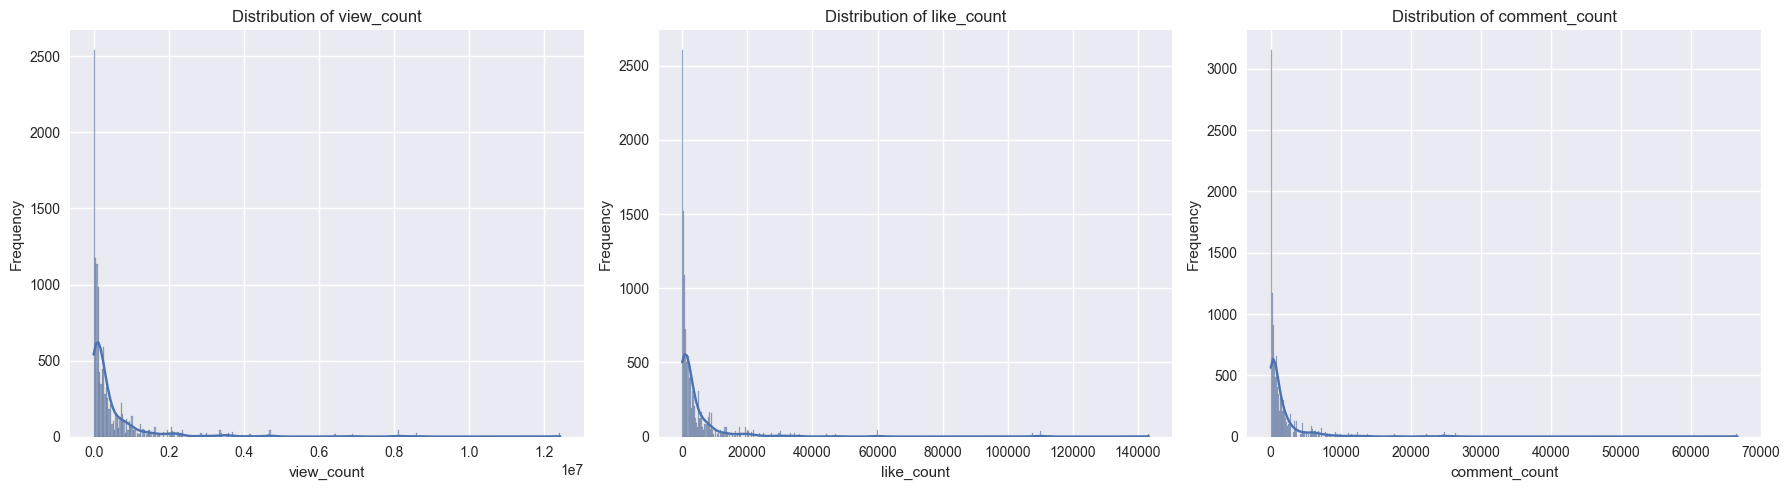

In [5]:
# Create a figure with three subplots using a 1x3 grid
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Loop over the columns and plot a histogram on each subplot
for ax, column in zip(axes, columns):
    sns.histplot(data=videos_comments_left[column], ax=ax, bins='auto', kde=True) # the bin is auto, the kde is kernel density plot
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Customize and display the plot
plt.tight_layout()
plt.show()

In [6]:
videos_comments_left[columns].skew()

view_count      5.72
like_count      7.32
comment_count   8.87
dtype: float64

**Observation 1:**

All of the the the graphs indicate a right skewed. The peak of all three graphs is near the beginning. The histogram is quite hard to interpret, so for individual details, I will use a boxplot and discuss in their own observation.

**1.1. Observation view count:** 

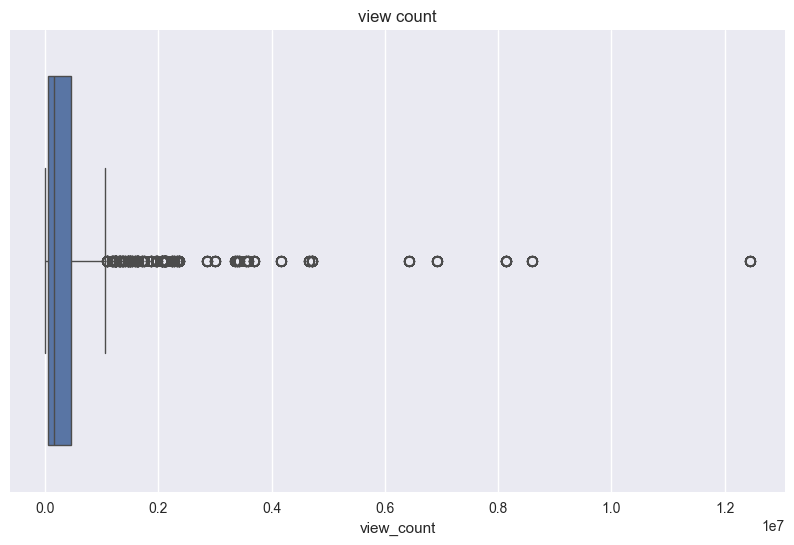

0.00        149.00
0.25      44990.00
0.50     148637.00
0.75     456817.00
1.00   12442397.00
Name: view_count, dtype: float64

Lower bound: -572750.5 
Upper bound: 1074557.5


In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=videos_comments_left['view_count'], orient='h')
plt.title('view count')
plt.show()
print(videos_comments_left['view_count'].quantile([0, 0.25, 0.5, 0.75, 1]))

# Calculate the upper and lower bounds
Q1 = videos_comments_left['view_count'].quantile(0.25)
Q3 = videos_comments_left['view_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"\nLower bound: {lower_bound} \nUpper bound: {upper_bound}")

Side note: le7 is $10^7$. E.g. 0.2 will become 2,000,000

For the view count graph, most video views about Covid19 is between 44990 and 456817. If we look at the min and max, we can see a wide rage between 149 to 12442397 views; combining with the how much outliers we can see in the graph, this is indeed a right skewed distribution. Any videos above 1074557.5 views are considered outliers.

**Finding out the most viewed videos**

In [8]:
videos_comments_left.columns

Index(['video_id', 'channel_id', 'video_title', 'channel_title',
       'category_name', 'live_upcoming_none', 'view_count', 'like_count',
       'dislike_count', 'comment_count', 'published_at', 'tags', 'duration',
       'definition', 'caption', 'thumbnail', 'url', 'published_at_week',
       'published_at_month', 'published_at_year', 'comment_id', 'comment_text',
       'comment_author', 'comment_date', 'comment_like_count',
       'parent_comment_id', 'comment_date_week', 'comment_date_month',
       'comment_date_year'],
      dtype='object')

In [9]:
max_view = videos_comments_left.sort_values('view_count', ascending=False).drop_duplicates('video_title').head()
max_view = max_view[['channel_title', 'video_title', 'view_count', 'published_at']]
max_view

,channel_title,video_title,view_count,published_at
2370,CNN,bill gates makes a prediction about when coron...,12442397,2020-03-27 03:52:55
1432,BBC News,coronavirus in india inside a mumbai hospital icu,8601239,2020-06-26 11:16:06
7635,The New York Times,people are dying battling coronavirus inside a...,8139164,2020-03-26 13:30:07
518,Fox News,tucker big tech censors dissent over coronavir...,6920336,2020-04-29 00:51:40
11155,Washington Post,the dos and donts of holiday travel during the...,6424841,2020-10-27 13:35:10


So the most viewed video has the title of "Bill Gates makes a prediction about when coronavirus cases will peak" by CNN at 2020-03-12. The other 4 most viewed videos are also in 2020, very interesting. This can be used as a reference for the next question.

**1.2. Observation like count:** 

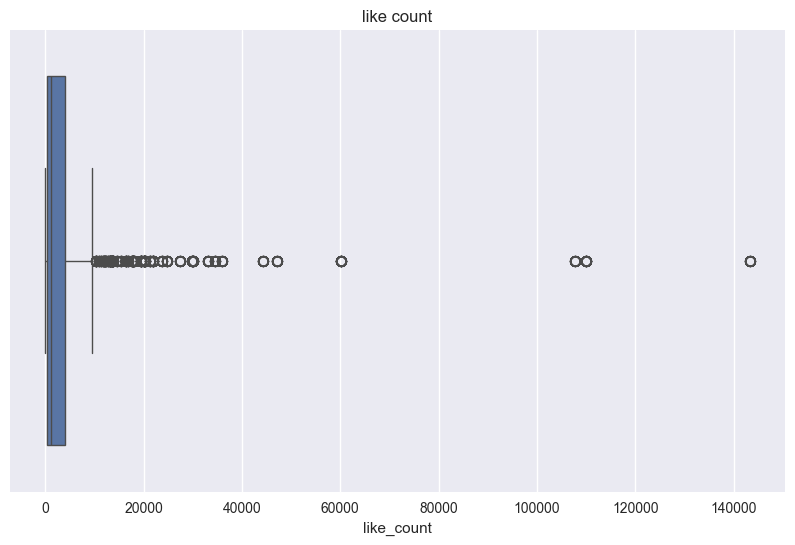

0.00        3.00
0.25      396.00
0.50     1273.00
0.75     4102.00
1.00   143279.00
Name: like_count, dtype: float64

Lower bound: -5163.0 
Upper bound: 9661.0


In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=videos_comments_left['like_count'], orient='h')
plt.title('like count')
plt.show()
print(videos_comments_left['like_count'].quantile([0, 0.25, 0.5, 0.75, 1]))

# Calculate the upper and lower bounds
Q1 = videos_comments_left['like_count'].quantile(0.25)
Q3 = videos_comments_left['like_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"\nLower bound: {lower_bound} \nUpper bound: {upper_bound}")

For the like count graph, most video like about covid 19 is between 396 and 4102. If we look at the min and max, we can see a wide rage between 3 to 143279 likes; combining with the how much outliers we can see in the graph, this is indeed a right skewed distribution. Any videos above 9661 likes are considered outliers.

**Finding out the most liked videos**

In [11]:
# I want to compare the most views and most liked video
max_view

,channel_title,video_title,view_count,published_at
2370,CNN,bill gates makes a prediction about when coron...,12442397,2020-03-27 03:52:55
1432,BBC News,coronavirus in india inside a mumbai hospital icu,8601239,2020-06-26 11:16:06
7635,The New York Times,people are dying battling coronavirus inside a...,8139164,2020-03-26 13:30:07
518,Fox News,tucker big tech censors dissent over coronavir...,6920336,2020-04-29 00:51:40
11155,Washington Post,the dos and donts of holiday travel during the...,6424841,2020-10-27 13:35:10


In [12]:
max_like = videos_comments_left.sort_values('like_count', ascending=False).drop_duplicates('like_count').head()
max_like = max_like[['channel_title', 'video_title', 'like_count', 'published_at']]
max_like

,channel_title,video_title,like_count,published_at
521,Fox News,tucker big tech censors dissent over coronavir...,143279,2020-04-29 00:51:40
7614,The New York Times,people are dying battling coronavirus inside a...,110067,2020-03-26 13:30:07
2379,CNN,bill gates makes a prediction about when coron...,107692,2020-03-27 03:52:55
8417,The New York Times,china is censoring coronavirus stories these c...,60068,2020-02-25 00:00:08
7258,Guardian News,coronavirus germans sing bella ciao from rooft...,47107,2020-03-21 10:34:06


There is an overlap of 3 videos that have the most liked and viewed. Also, the most liked video are in 2020, and all of them are during the period where WHO declares COVID19 as a global pandemic.

**1.3. Observation comment count:** 

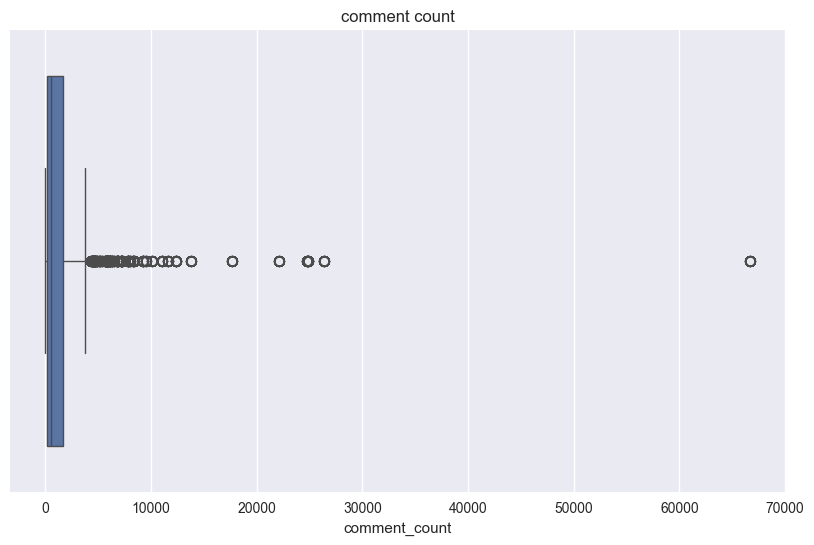

0.00       0.00
0.25     133.00
0.50     575.00
0.75    1729.00
1.00   66667.00
Name: comment_count, dtype: float64

Lower bound: -2261.0 
Upper bound: 4123.0


In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=videos_comments_left['comment_count'], orient='h')
plt.title('comment count')
plt.show()
print(videos_comments_left['comment_count'].quantile([0, 0.25, 0.5, 0.75, 1]))

# Calculate the upper and lower bounds
Q1 = videos_comments_left['comment_count'].quantile(0.25)
Q3 = videos_comments_left['comment_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"\nLower bound: {lower_bound} \nUpper bound: {upper_bound}")

For the like comment graph, most video comments about covid 19 is between 133 and 1729. If we look at the min and max, we can see a wide rage between 0 to 66667 comments; combining with the how much outliers we can see in the graph, this is indeed a right skewed distribution. Any video above 1729 comments are considered outliers. This can be used as a reference for the next question.

**Finding out the most commented videos**

In [14]:
display(max_like)
display(max_view)

,channel_title,video_title,like_count,published_at
521,Fox News,tucker big tech censors dissent over coronavir...,143279,2020-04-29 00:51:40
7614,The New York Times,people are dying battling coronavirus inside a...,110067,2020-03-26 13:30:07
2379,CNN,bill gates makes a prediction about when coron...,107692,2020-03-27 03:52:55
8417,The New York Times,china is censoring coronavirus stories these c...,60068,2020-02-25 00:00:08
7258,Guardian News,coronavirus germans sing bella ciao from rooft...,47107,2020-03-21 10:34:06


,channel_title,video_title,view_count,published_at
2370,CNN,bill gates makes a prediction about when coron...,12442397,2020-03-27 03:52:55
1432,BBC News,coronavirus in india inside a mumbai hospital icu,8601239,2020-06-26 11:16:06
7635,The New York Times,people are dying battling coronavirus inside a...,8139164,2020-03-26 13:30:07
518,Fox News,tucker big tech censors dissent over coronavir...,6920336,2020-04-29 00:51:40
11155,Washington Post,the dos and donts of holiday travel during the...,6424841,2020-10-27 13:35:10


In [15]:
max_cmt = videos_comments_left.sort_values('comment_count', ascending=False).drop_duplicates('video_title').head()
max_cmt = max_cmt[['channel_title', 'video_title', 'comment_count', 'published_at']]
max_cmt

,channel_title,video_title,comment_count,published_at
2390,CNN,bill gates makes a prediction about when coron...,66667,2020-03-27 03:52:55
9465,ABC News,asians facing discrimination violence amid cor...,26402,2020-03-13 02:37:59
7605,The New York Times,people are dying battling coronavirus inside a...,24857,2020-03-26 13:30:07
512,Fox News,tucker big tech censors dissent over coronavir...,24727,2020-04-29 00:51:40
2530,CNN,see where officials believe the coronavirus st...,22132,2020-01-21 02:47:47


Very interesting indeed, there are 3 overlap videos between the most comments, viewed and liked data frame. The 4 most commented video are published when WHO declares COVID19 as a global pandemic.

**This analyzing is out of the scope of the question, but I want to find the correlation between these 3**

In [16]:
correlation = videos_comments_left[['comment_count', 'view_count', 'like_count']].corr()
correlation

,comment_count,view_count,like_count
comment_count,1.00,0.81,0.79
view_count,0.81,1.00,0.88
like_count,0.79,0.88,1.00


Very strongly correlated, which is a good starting point to determine the causation. But because I can only present in 12 minutes and prove whether the 3 variables have causation relationship or not are long and difficult. So I won't be doing that.

#### E.1.3. How has the number of comments changed over time? Use visualization to answer this question and annotate at least three major events related to Covid-19 (e.g., WHO declares pandemic) on your plot. Additionally, analyze the plot and try to identify any relationship between these events and the changes in the number of comments; discuss your observations.

In [17]:
# Look for useful features
videos_comments_left.columns

Index(['video_id', 'channel_id', 'video_title', 'channel_title',
       'category_name', 'live_upcoming_none', 'view_count', 'like_count',
       'dislike_count', 'comment_count', 'published_at', 'tags', 'duration',
       'definition', 'caption', 'thumbnail', 'url', 'published_at_week',
       'published_at_month', 'published_at_year', 'comment_id', 'comment_text',
       'comment_author', 'comment_date', 'comment_like_count',
       'parent_comment_id', 'comment_date_week', 'comment_date_month',
       'comment_date_year'],
      dtype='object')

In [18]:
# Group the data by month and sum the comments for each month
comment_per_month = videos_comments_left.resample('M', on='published_at')['comment_count'].sum()
comment_per_month.head()

published_at
2020-01-31     557153
2020-02-29    1236746
2020-03-31    8101365
2020-04-30    5443847
2020-05-31    1460834
Freq: ME, Name: comment_count, dtype: int64

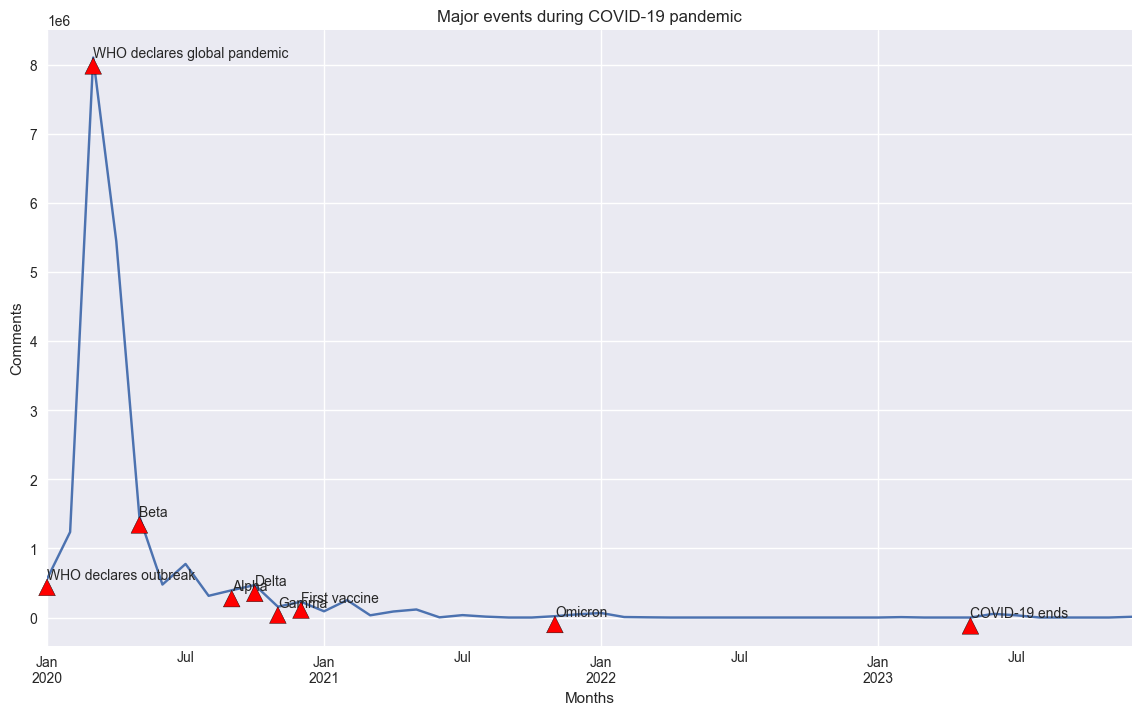

In [19]:
# Plot comments_by_week 
fig, ax = plt.subplots()
comment_per_month.plot(kind='line', ax=ax, figsize=(14, 8))

# Annonate the major events on the plot ..
events = { # events dictionary 
    '2020-01-31': 'WHO declares outbreak',
    '2020-03-31': 'WHO declares global pandemic',
    '2020-05-31': 'Beta',
    '2020-09-30': 'Alpha',
    '2020-10-31': 'Delta',
    '2020-11-30': 'Gamma',
    '2020-12-31': 'First vaccine',
    '2021-11-30': 'Omicron',
    '2023-05-31': 'COVID-19 ends'
}

for month, event in events.items():
    try:
        y = comment_per_month[month]
        ax.annotate(event, xy=(month, y), arrowprops=dict(facecolor='red'))
    except KeyError:
        print(f"No data for month {month}")

# Customize and display the plot
ax.set_title('Major events during COVID-19 pandemic')
ax.set_xlabel('Months')
ax.set_ylabel('Comments')
plt.show()

**Observation 1:**

Within a month from declaring an outbreak to global pandemic on January of 2020 by WHO, people attention for it skyrocked. At its peak, when WHO declares COVID19 as a global pandemic, there a total of 8 million comments through out the 13 popular news channel combined. 

**Observation 2:** 

The following months we see the decline of interest, but the comments were still in the hundred of thousands.

**Observation from the previous question**

From previous question where we find the distributions of the number of views, likes, and comments for the videos. Almost all of the top 5 videos in the 3 category, possibly extended to 10, are published around March, when WHO declares COVID19 as a global pandemic.

#### E.2.3. How has the total number of comments per news publisher (channel) changed over months? Create a visualization to investigate this and discuss your observations. Make sure the outliers have been removed. 

In [20]:
# Getting all available columns
videos_comments_left.columns

Index(['video_id', 'channel_id', 'video_title', 'channel_title',
       'category_name', 'live_upcoming_none', 'view_count', 'like_count',
       'dislike_count', 'comment_count', 'published_at', 'tags', 'duration',
       'definition', 'caption', 'thumbnail', 'url', 'published_at_week',
       'published_at_month', 'published_at_year', 'comment_id', 'comment_text',
       'comment_author', 'comment_date', 'comment_like_count',
       'parent_comment_id', 'comment_date_week', 'comment_date_month',
       'comment_date_year'],
      dtype='object')

In [21]:
# See all of the channels
videos_comments_left['channel_title'].unique()

array(['Fox News', 'BBC News', 'CNN', 'MSNBC', 'Sky News', 'NBC News',
       'Guardian News', 'The New York Times', 'ABC News',
       'Washington Post', 'CBS News', 'PBS NewsHour', 'Times Radio'],
      dtype=object)

In [22]:
# Selected channels
channels_to_plot = ['ABC News', 'BBC News', 'The New York Times', 'CNN', 'Fox News', 'Washington Post']

,channel_title,published_at_month,comment_count
0,Fox News,2020-03,1941
1,Fox News,2020-03,1941
2,Fox News,2020-03,1941
3,Fox News,2020-03,1941
4,Fox News,2020-03,1941


We need to drop duplicates


,channel_title,published_at_month,comment_count
0,Fox News,2020-03,1941
23,Fox News,2020-02,2284
43,Fox News,2020-11,245
63,Fox News,2020-04,4713
83,Fox News,2020-03,2885


(290, 3)

Group channel title and month of published by the total comments


,channel_title,published_at_month,comment_count
0,ABC News,2020-01,3745
1,ABC News,2020-02,7470
2,ABC News,2020-03,66050
3,ABC News,2020-04,16469
4,ABC News,2020-05,7344
...,...,...,...
69,Washington Post,2021-01,0
70,Washington Post,2021-02,51
71,Washington Post,2021-06,119
72,Washington Post,2021-12,2122


(74, 3)

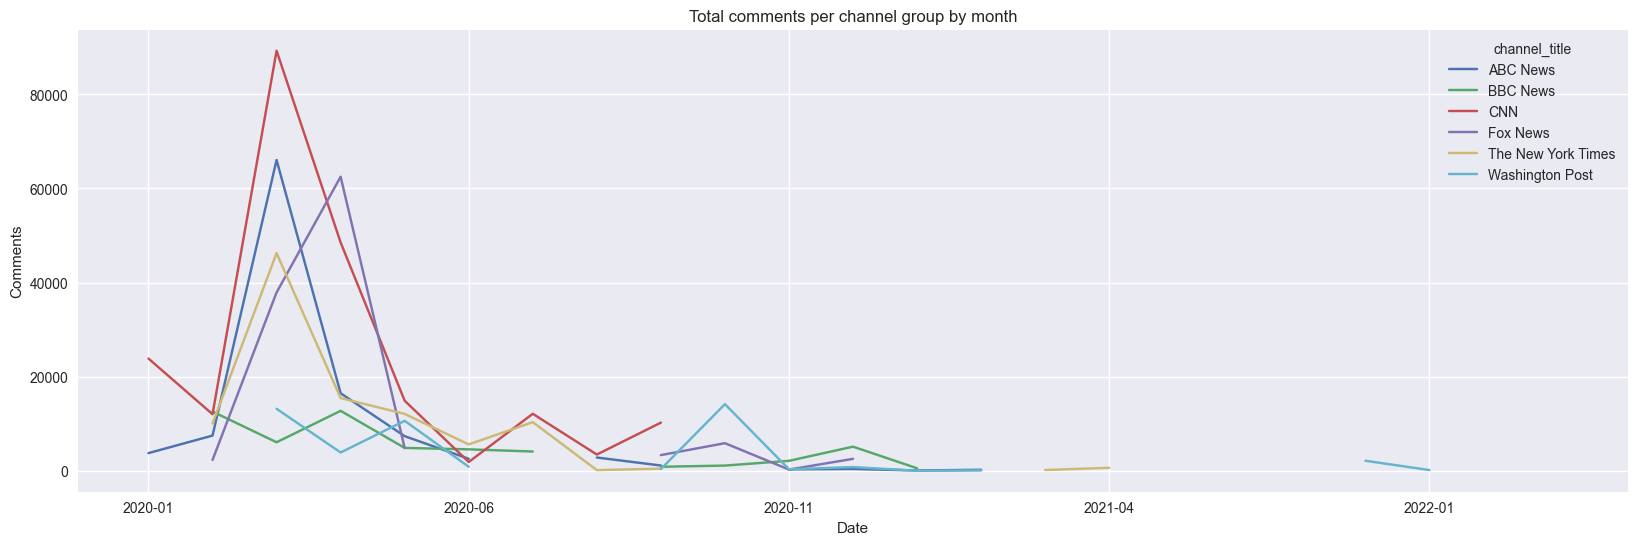

In [23]:
# Convert the published_at column to a datetime object and extract year and month
# No need coz we already have `published_at_month`
display(videos_comments_left[['channel_title', 'published_at_month', 'comment_count']].head())
print("We need to drop duplicates")
df = videos_comments_left[['channel_title', 'published_at_month', 'comment_count']].drop_duplicates(['published_at_month', 'comment_count']) # drop duplicates
df = df[df['channel_title'].isin(channels_to_plot)] # select only a couple of channels
display(df.head(), df.shape)

# Calculate the total number of comments per channel_title and year_month
total_comments = df.groupby(['channel_title', 'published_at_month'])['comment_count'].sum().reset_index()
print("Group channel title and month of published by the total comments")
display(total_comments, total_comments.shape)

# Plotting the time series of selected channels before removing the outlier
pivot_table = pd.pivot_table(data=total_comments, values='comment_count', index='published_at_month', columns='channel_title')
pivot_table.plot(kind='line', figsize=(20, 6))
plt.xlabel('Date')
plt.ylabel('Comments')
plt.title('Total comments per channel group by month')
plt.show()

**Observation 1**

From my point of view, we do not need to remove the outliers when dealing with time series data, because it will mess with the plotting. Here, I plot a time series of comments per selected channels over time. As we can see, the density of comments are situated around January of 2020 to June of 2020, the peak of COVID 19 popularity. I can relate this line plot with previous question's plot because a lot of major covid events happened during those times. 

The lines are a bit disconnected because some data are omitted. Omitted means it doesn't exist. The lines will be even more disconnected once we removed the outliers. I will show it in the second observations.

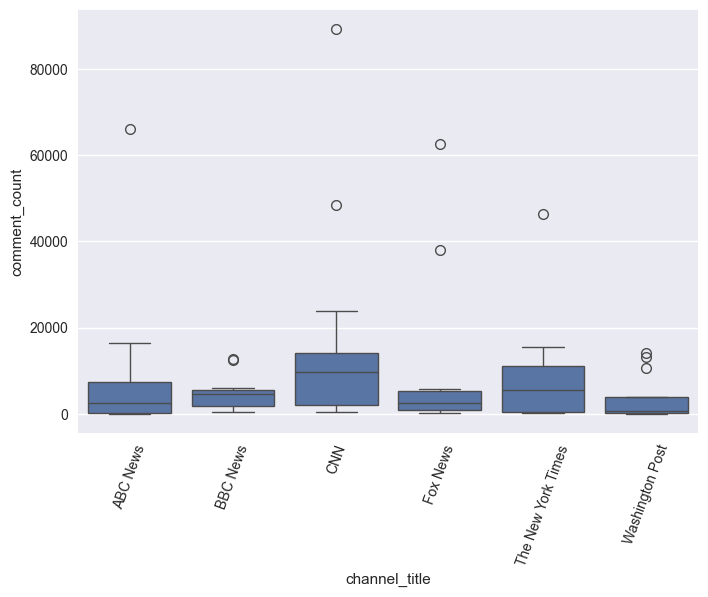

,channel_title,published_at_month,comment_count
0,ABC News,2020-01,3745
1,ABC News,2020-02,7470
3,ABC News,2020-04,16469
4,ABC News,2020-05,7344
5,ABC News,2020-06,2535
...,...,...,...
69,Washington Post,2021-01,0
70,Washington Post,2021-02,51
71,Washington Post,2021-06,119
72,Washington Post,2021-12,2122


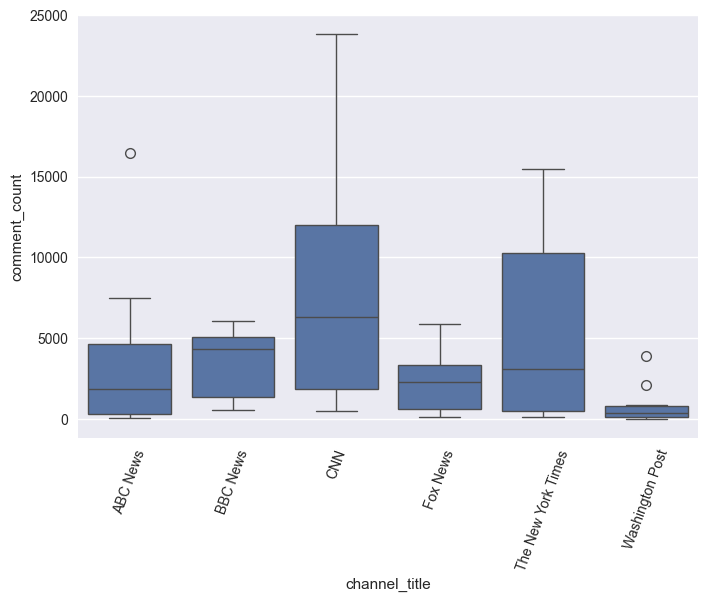

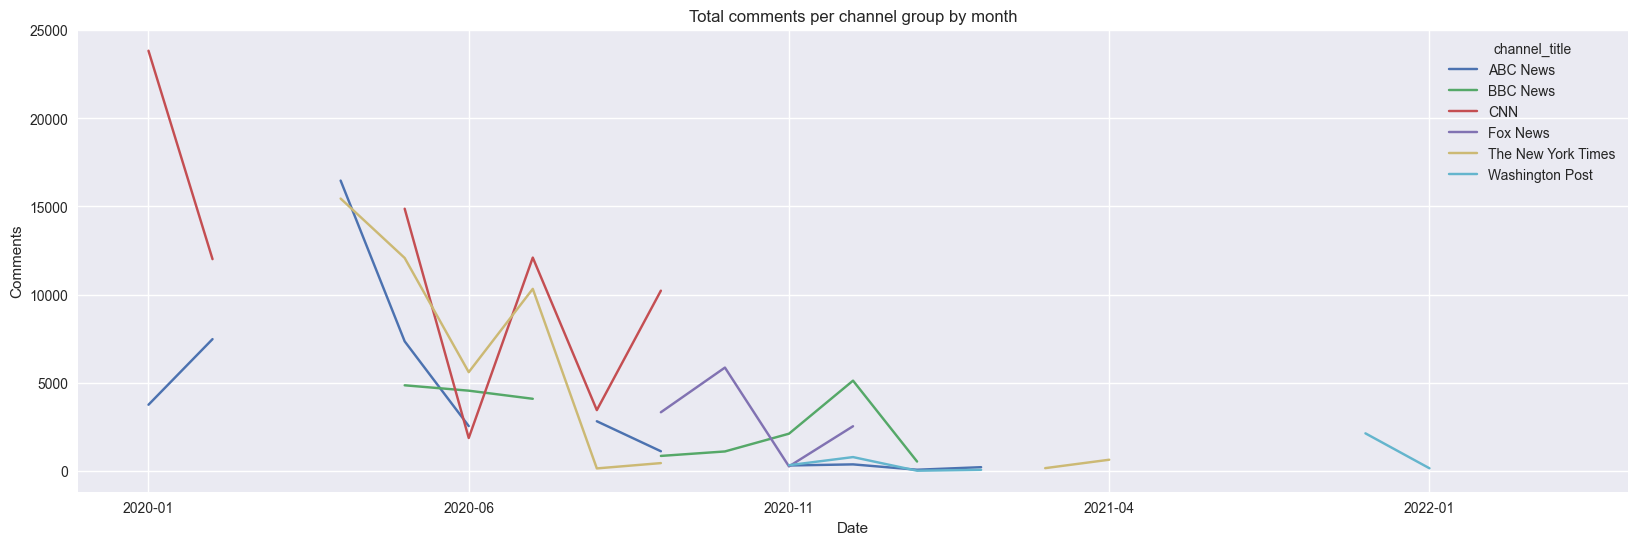

In [24]:
# Check out the outliers
sns.boxplot(data=total_comments, x='channel_title', y='comment_count')
plt.xticks(rotation=70)
plt.show()
# Remove outliers using IQR
reduced_outliers = pd.DataFrame()

for channel in total_comments['channel_title'].unique(): # loop through each channel
    # select data for the current channel
    data = total_comments[total_comments['channel_title'] == channel]
    
    # IQR calculation
    Q1 = data['comment_count'].quantile(0.25)
    Q3 = data['comment_count'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Filter out the outliers
    filter = (data['comment_count'] >= Q1 - 1.5*IQR) & (data['comment_count'] <= Q3 + 1.5*IQR)
    filtered_data = data[filter]
    
    # Append filtered data to results DataFrame
    reduced_outliers = pd.concat([reduced_outliers, filtered_data])
display(reduced_outliers)

sns.boxplot(data=reduced_outliers, x='channel_title', y='comment_count')
plt.xticks(rotation=70)
plt.show()

# Create a pivot table to group the data by year_month and channel_title
# Create, customize, and display the plot
pivot_table = pd.pivot_table(data=reduced_outliers, values='comment_count', index='published_at_month', columns='channel_title')
pivot_table.plot(kind='line', figsize=(20, 6))
plt.xlabel('Date')
plt.ylabel('Comments')
plt.title('Total comments per channel group by month')
plt.show()

**Observation 2**

I have removed the outlier using IQR. Anything above the upper and lower limit will be removed. This causes the lines to be uninterpretable. The reason why is because these outliers are natural variations, it happens naturally though out the COVID 19 period. So, there is no reason to remove them.